In [1]:
import pandas as pd
import numpy as np

df = pd.read_parquet("/home/niclas/ATOW-Prediction/additional_data/T100_data/t100_segment_data.parquet")
aircraft_types = pd.read_csv("/home/niclas/ATOW-Prediction/additional_data/T100_data/L_AIRCRAFT_TYPE.csv")

In [2]:
aircraft_types.rename(columns={"Code": "AIRCRAFT_TYPE", "Description": "Aircraft Name"}, inplace=True)
df = df.merge(aircraft_types)


In [3]:
df["Aircraft Name"].value_counts()


Aircraft Name
Boeing 737-800                                  717046
Airbus Industrie A320-100/200                   681899
Boeing 757-200                                  604568
Boeing 737-300                                  533863
McDonnell Douglas DC9 Super 80/MD81/82/83/88    506660
                                                 ...  
Cessna 205                                           1
Aerospatiale Caravelle SE-210                        1
Lockheed L-649                                       1
Convair 990 Coronado (CV-30)                         1
McDonnell Douglas DC-10-20                           1
Name: count, Length: 328, dtype: int64

In [4]:
df.columns

Index(['DEPARTURES_SCHEDULED', 'DEPARTURES_PERFORMED', 'PAYLOAD', 'SEATS',
       'PASSENGERS', 'FREIGHT', 'MAIL', 'DISTANCE', 'RAMP_TO_RAMP', 'AIR_TIME',
       'UNIQUE_CARRIER', 'AIRLINE_ID', 'UNIQUE_CARRIER_NAME',
       'UNIQUE_CARRIER_ENTITY', 'REGION', 'CARRIER', 'CARRIER_NAME',
       'CARRIER_GROUP', 'CARRIER_GROUP_NEW', 'ORIGIN_AIRPORT_ID',
       'ORIGIN_AIRPORT_SEQ_ID', 'ORIGIN_CITY_MARKET_ID', 'ORIGIN',
       'ORIGIN_CITY_NAME', 'ORIGIN_STATE_ABR', 'ORIGIN_STATE_FIPS',
       'ORIGIN_STATE_NM', 'ORIGIN_COUNTRY', 'ORIGIN_COUNTRY_NAME',
       'ORIGIN_WAC', 'DEST_AIRPORT_ID', 'DEST_AIRPORT_SEQ_ID',
       'DEST_CITY_MARKET_ID', 'DEST', 'DEST_CITY_NAME', 'DEST_STATE_ABR',
       'DEST_STATE_FIPS', 'DEST_STATE_NM', 'DEST_COUNTRY', 'DEST_COUNTRY_NAME',
       'DEST_WAC', 'AIRCRAFT_GROUP', 'AIRCRAFT_TYPE', 'AIRCRAFT_CONFIG',
       'YEAR', 'QUARTER', 'MONTH', 'DISTANCE_GROUP', 'CLASS', 'DATA_SOURCE',
       'Aircraft Name'],
      dtype='object')

In [5]:
# Define columns that make sense to divide by DEPARTURES_PERFORMED
columns_to_divide = [
    'PAYLOAD', 'SEATS', 'PASSENGERS', 'FREIGHT', 'MAIL', 'DISTANCE',
    'RAMP_TO_RAMP', 'AIR_TIME'
]

# Ensure all specified columns exist in the dataframe
columns_to_divide = [col for col in columns_to_divide if col in df.columns]

# Divide each relevant column by DEPARTURES_PERFORMED, handling division by zero
for col in columns_to_divide:
    new_col_name = f'{col}_PER_DEPARTURE'
    df[new_col_name] = np.where(
        df['DEPARTURES_PERFORMED'] != 0,
        df[col] / df['DEPARTURES_PERFORMED'],
        np.inf  # or you could use np.nan if you prefer
    )

# Calculate load factor (if not already present)
if 'PASSENGERS' in df.columns and 'SEATS' in df.columns:
    df['LOAD_FACTOR'] = np.where(
        df['SEATS'] != 0,
        df['PASSENGERS'] / df['SEATS'],
        np.nan
    )


In [6]:
df.head()

,DEPARTURES_SCHEDULED,DEPARTURES_PERFORMED,PAYLOAD,SEATS,PASSENGERS,FREIGHT,MAIL,DISTANCE,RAMP_TO_RAMP,AIR_TIME,...,Aircraft Name,PAYLOAD_PER_DEPARTURE,SEATS_PER_DEPARTURE,PASSENGERS_PER_DEPARTURE,FREIGHT_PER_DEPARTURE,MAIL_PER_DEPARTURE,DISTANCE_PER_DEPARTURE,RAMP_TO_RAMP_PER_DEPARTURE,AIR_TIME_PER_DEPARTURE,LOAD_FACTOR
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Saab-Fairchild 340/B,inf,inf,inf,inf,inf,inf,inf,inf,NaN
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.0,0.0,0.0,...,Cessna C206/207/209/210 Stationair,inf,inf,inf,inf,inf,inf,inf,inf,NaN
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.0,0.0,0.0,...,Cessna C206/207/209/210 Stationair,inf,inf,inf,inf,inf,inf,inf,inf,NaN
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.0,0.0,0.0,...,Cessna C206/207/209/210 Stationair,inf,inf,inf,inf,inf,inf,inf,inf,NaN
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.0,0.0,0.0,...,Cessna C206/207/209/210 Stationair,inf,inf,inf,inf,inf,inf,inf,inf,NaN


<Axes: xlabel='AIR_TIME_PER_DEPARTURE', ylabel='PAYLOAD'>

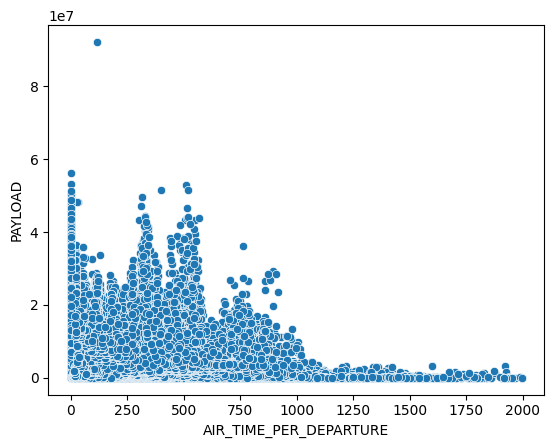

In [7]:
import seaborn as sns
sns.scatterplot(df[df["AIR_TIME_PER_DEPARTURE"] < 2000], x="AIR_TIME_PER_DEPARTURE", y="PAYLOAD")

<Axes: >

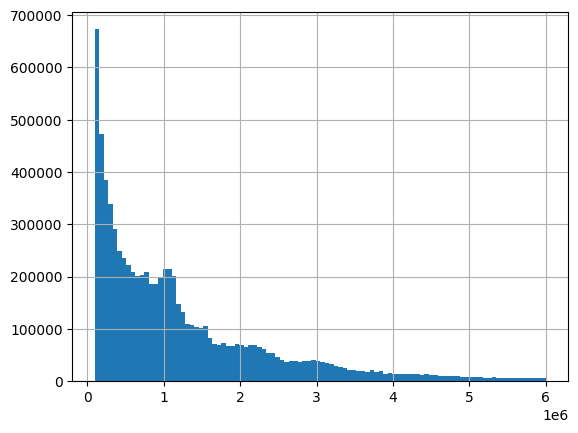

In [8]:
df[(df.PAYLOAD > 100000) & (df.PAYLOAD < 6e6)].PAYLOAD.hist(bins=100)

In [9]:
ddf = df[df["SEATS"] > 0]
load = (ddf["PASSENGERS"] / ddf["SEATS"])
load = load[load.notna() & (load <= 1.01) & (load > 0)]

<Axes: >

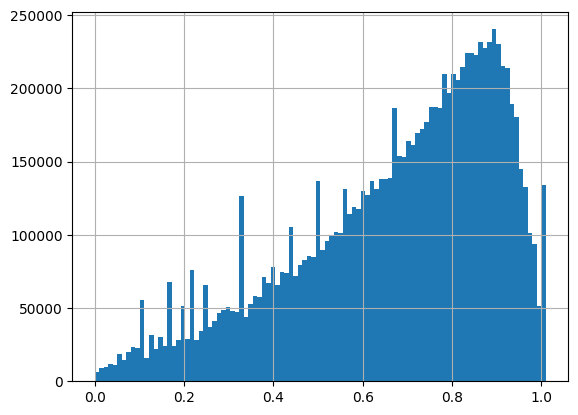

In [10]:
load.hist(bins=100)

In [11]:
len(load)

10605815

In [12]:
eps = 1e-6
df["load_factor"] = df["PASSENGERS"] / (df["SEATS"] + eps)

In [13]:
import numpy as np
df["wpp"] = (df["PAYLOAD"] / df["PASSENGERS"])
df.replace([np.inf, -np.inf], np.nan, inplace=True)

<Axes: >

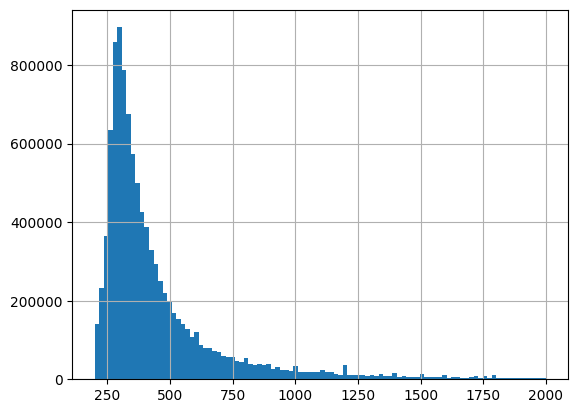

In [14]:
df[(df.wpp < 2000) & (df.wpp > 200)].wpp.hist(bins=100)

In [15]:
df.DEST_COUNTRY_NAME.value_counts().to_dict()

{'United States': 11697122,
 'Canada': 228267,
 'Mexico': 214126,
 'United Kingdom': 65813,
 'Japan': 52506,
 'Germany': 42738,
 'Dominican Republic': 38574,
 'The Bahamas': 35404,
 'France': 28536,
 'Brazil': 27731,
 'Colombia': 26700,
 'South Korea': 26053,
 'Jamaica': 24863,
 'Netherlands': 24597,
 'Costa Rica': 16636,
 'China': 14222,
 'El Salvador': 14180,
 'Italy': 13333,
 'Venezuela': 12906,
 'Guatemala': 12697,
 'Aruba': 12578,
 'Spain': 12382,
 'Panama': 12125,
 'Honduras': 11302,
 'Belgium': 10929,
 'Ireland': 10760,
 'Taiwan': 9754,
 'Switzerland': 9612,
 'Ecuador': 8930,
 'Cuba': 8823,
 'Hong Kong': 8715,
 'Peru': 8458,
 'Australia': 8402,
 'Cayman Islands': 8320,
 'Netherlands Antilles': 7402,
 'Trinidad and Tobago': 6992,
 'Bermuda': 6713,
 'Turks and Caicos Islands': 6480,
 'Haiti': 6236,
 'Argentina': 6082,
 'Barbados': 5552,
 'Iceland': 5534,
 'Chile': 5534,
 'Israel': 5464,
 'Belize': 5374,
 'Nicaragua': 5089,
 'Portugal': 4748,
 'Russia': 4437,
 'Antigua and Barbuda'

<Axes: xlabel='SEATS_PER_DEPARTURE', ylabel='PASSENGERS_PER_DEPARTURE'>

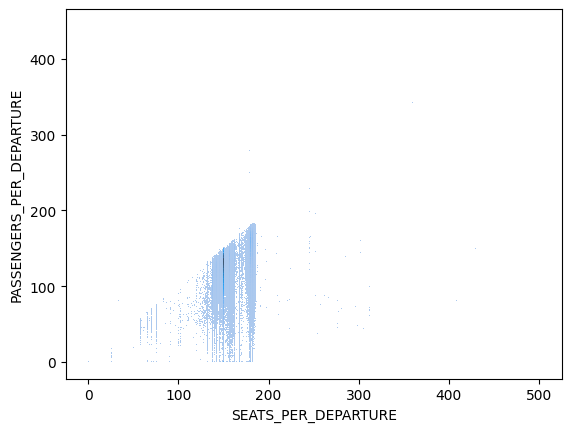

In [16]:
a320 = df[df["Aircraft Name"] == "Airbus Industrie A320-100/200"]
import seaborn as sns
import matplotlib.pyplot as plt
sns.histplot(a320, x="SEATS_PER_DEPARTURE", y="PASSENGERS_PER_DEPARTURE")

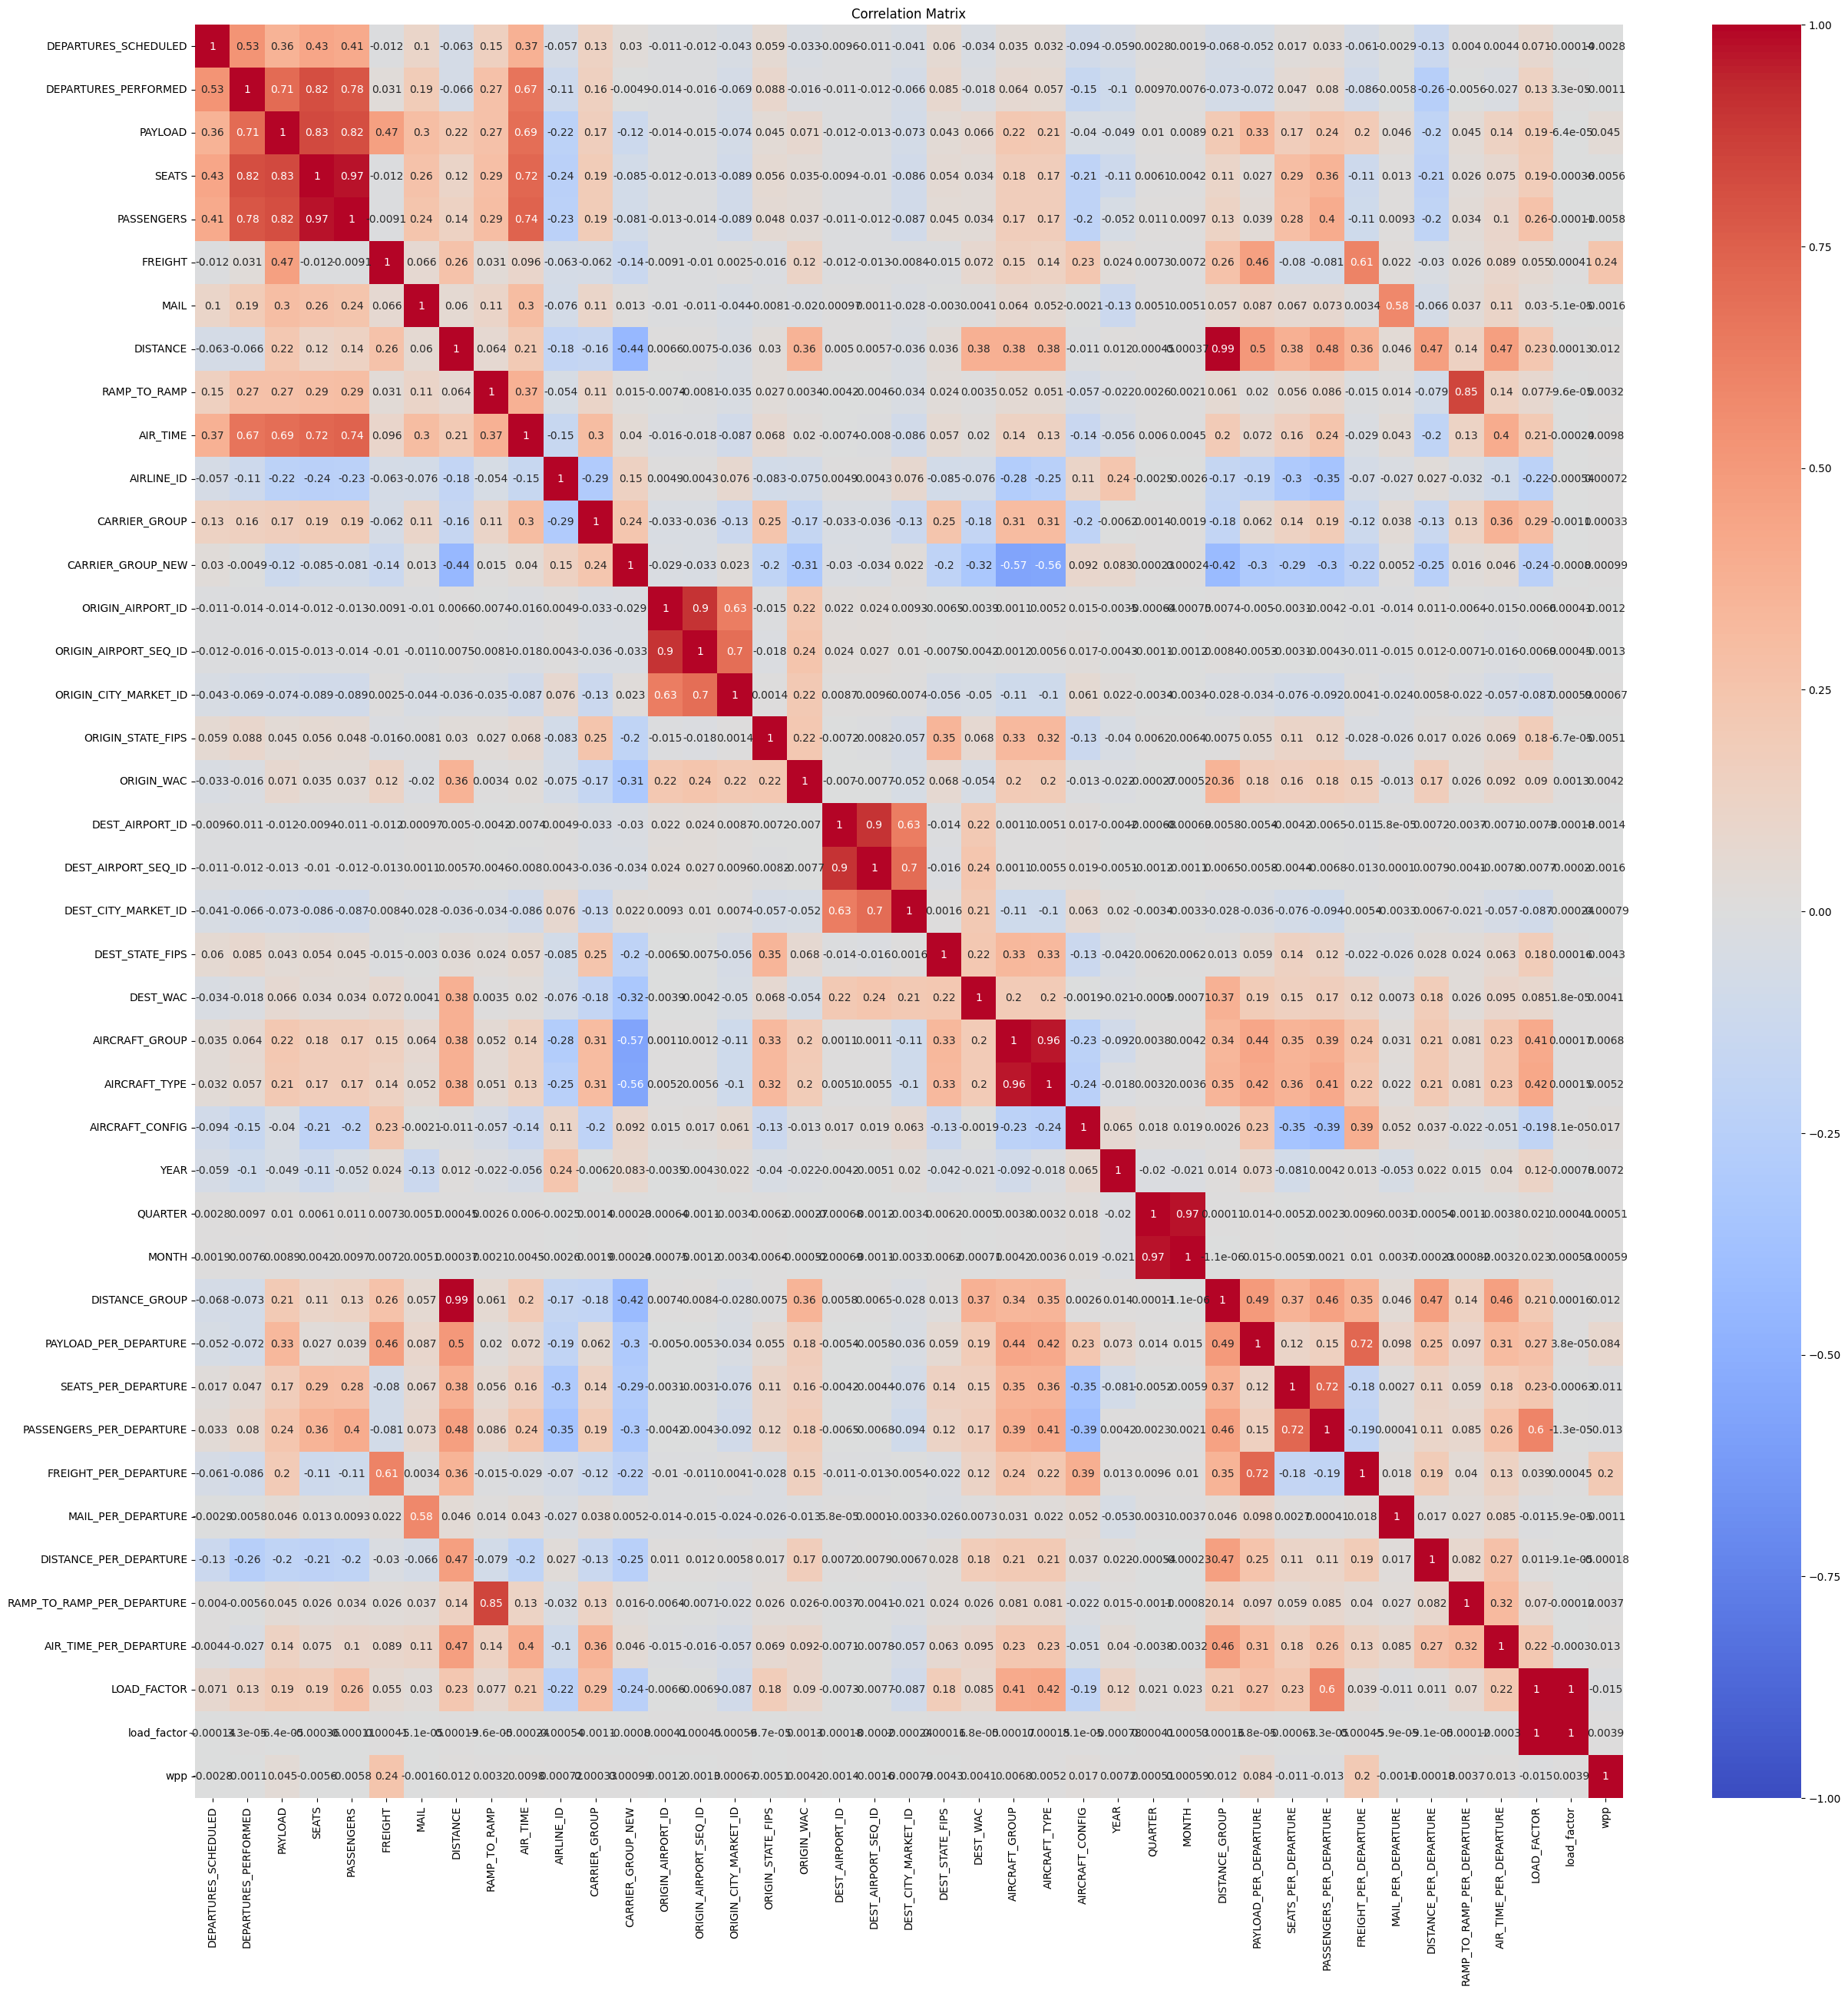

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select only numeric columns
numeric_df = df.select_dtypes(include=['int64', 'float64'])

# Create the correlation matrix
corr_matrix = numeric_df.corr()

# Create a heatmap using Seaborn
plt.figure(figsize=(30, 30))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Matrix')
plt.show()

In [18]:
df["AIRCRAFT_TYPE"]

0           456
1            35
2            35
3            35
4            35
           ... 
12944667    461
12944668    491
12944669    491
12944670    125
12944671    125
Name: AIRCRAFT_TYPE, Length: 12944672, dtype: int64

In [19]:
df

,DEPARTURES_SCHEDULED,DEPARTURES_PERFORMED,PAYLOAD,SEATS,PASSENGERS,FREIGHT,MAIL,DISTANCE,RAMP_TO_RAMP,AIR_TIME,...,SEATS_PER_DEPARTURE,PASSENGERS_PER_DEPARTURE,FREIGHT_PER_DEPARTURE,MAIL_PER_DEPARTURE,DISTANCE_PER_DEPARTURE,RAMP_TO_RAMP_PER_DEPARTURE,AIR_TIME_PER_DEPARTURE,LOAD_FACTOR,load_factor,wpp
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12944667,567.0,567.0,4437720.0,17550.0,12844.0,0.0,0.0,109.0,25441.0,16226.0,...,30.952381,22.652557,0.000000,0.000000,0.192240,44.869489,28.617284,0.731852,0.731852,345.509187
12944668,691.0,672.0,5779200.0,24864.0,18462.0,34988.0,28.0,129.0,34279.0,27049.0,...,37.000000,27.473214,52.065476,0.041667,0.191964,51.010417,40.251488,0.742519,0.742519,313.032174
12944669,694.0,667.0,5736200.0,24679.0,18951.0,36627.0,0.0,129.0,31823.0,25127.0,...,37.000000,28.412294,54.913043,0.000000,0.193403,47.710645,37.671664,0.767900,0.767900,302.685874
12944670,1000.0,987.0,1776000.0,8883.0,4998.0,0.0,0.0,30.0,19543.0,15397.0,...,9.000000,5.063830,0.000000,0.000000,0.030395,19.800405,15.599797,0.562648,0.562648,355.342137
